# TESS Exoplanet Detection - Complete Machine Learning Pipeline v6

This notebook creates a comprehensive machine learning pipeline for exoplanet detection using the TESS (Transiting Exoplanet Survey Satellite) dataset.

## Project Objective
Using the TESS Objects of Interest (TOI) dataset to develop a 3-class classification model:
- **PC (Planet Candidate)**: Planet candidates
- **CP (Confirmed Planet)**: Confirmed planets  
- **FP (False Positive)**: False positives

## Pipeline Steps
1. **Data Loading and Exploratory Data Analysis**
2. **Data Preprocessing and Cleaning**
3. **Feature Engineering**
4. **Model Development and Training**
5. **Model Evaluation and Optimization**
6. **Results Analysis**

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_score, recall_score, f1_score, roc_auc_score,
                           roc_curve, precision_recall_curve)
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# XGBoost and LightGBM
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not installed. To install: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not installed. To install: pip install lightgbm")

# Graphics settings
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("Libraries loaded successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")

Kütüphaneler başarıyla yüklendi!
XGBoost kullanılabilir: True
LightGBM kullanılabilir: True


## 1. Data Loading and Initial Exploratory Analysis

In [ ]:
# Load TESS dataset
data_path = "TOI.csv"
df = pd.read_csv(data_path)

print("=== TESS Dataset General Information ===")
print(f"Dataset size: {df.shape}")
print(f"Number of columns: {df.shape[1]}")
print(f"Number of rows: {df.shape[0]}")
print("\n=== First 5 rows ===")
df.head()

=== TESS Veri Seti Genel Bilgileri ===
Veri seti boyutu: (7703, 87)
Sütun sayısı: 87
Satır sayısı: 7703

=== İlk 5 satır ===


,rowid,toi,toipfx,tid,ctoi_alias,pl_pnum,tfopwg_disp,rastr,ra,raerr1,...,st_loggerr2,st_logglim,st_loggsymerr,st_rad,st_raderr1,st_raderr2,st_radlim,st_radsymerr,toi_created,rowupdate
0,1,1000.01,1000,50365310,5.036531e+07,1,FP,07h29m25.85s,112.357708,NaN,...,-0.07,0,1,2.16986,0.072573,-0.072573,0,1,2019-07-24 15:58:33,2024-09-09 10:08:01
1,2,1001.01,1001,88863718,8.886372e+07,1,PC,08h10m19.31s,122.580465,NaN,...,-0.09,0,1,2.01000,0.090000,-0.090000,0,1,2019-07-24 15:58:33,2023-04-03 14:31:04
2,3,1002.01,1002,124709665,1.247097e+08,1,FP,06h58m54.47s,104.726966,NaN,...,NaN,0,1,5.73000,NaN,NaN,0,1,2019-07-24 15:58:33,2022-07-11 16:02:02
3,4,1003.01,1003,106997505,1.069975e+08,1,FP,07h22m14.39s,110.559945,NaN,...,-1.64,0,1,NaN,NaN,NaN,0,1,2019-07-24 15:58:33,2022-02-23 10:10:02
4,5,1004.01,1004,238597883,2.385979e+08,1,FP,08h08m42.77s,122.178195,NaN,...,-0.07,0,1,2.15000,0.060000,-0.060000,0,1,2019-07-24 15:58:33,2024-09-09 10:08:01


In [ ]:
# Dataset information
print("=== Data Types ===")
print(df.dtypes.value_counts())
print(f"\nNumerical columns: {df.select_dtypes(include=[np.number]).shape[1]}")
print(f"Categorical columns: {df.select_dtypes(include=['object']).shape[1]}")

print("\n=== Missing Values Analysis ===")
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percentage
}).sort_values('Missing_Percentage', ascending=False)

print("Columns with most missing values:")
print(missing_info[missing_info['Missing_Count'] > 0].head(10))

=== Veri Tipleri ===
float64    58
int64      24
object      5
Name: count, dtype: int64

Sayısal sütunlar: 82
Kategorik sütunlar: 5

=== Eksik Değer Analizi ===
En çok eksik değere sahip sütunlar:
                Missing_Count  Missing_Percentage
decerr2                  7703               100.0
pl_eqterr1               7703               100.0
pl_insolsymerr           7703               100.0
decerr1                  7703               100.0
pl_insolerr2             7703               100.0
raerr2                   7703               100.0
pl_insolerr1             7703               100.0
raerr1                   7703               100.0
pl_insollim              7703               100.0
pl_eqterr2               7703               100.0


=== Hedef Değişkeni Analizi (tfopwg_disp) ===
Sınıf dağılımı:
tfopwg_disp
PC     4679
FP     1197
CP      684
KP      583
APC     462
FA       98
Name: count, dtype: int64

Toplam sınıf sayısı: 6
En yaygın sınıf: PC (4679 örnekleri)


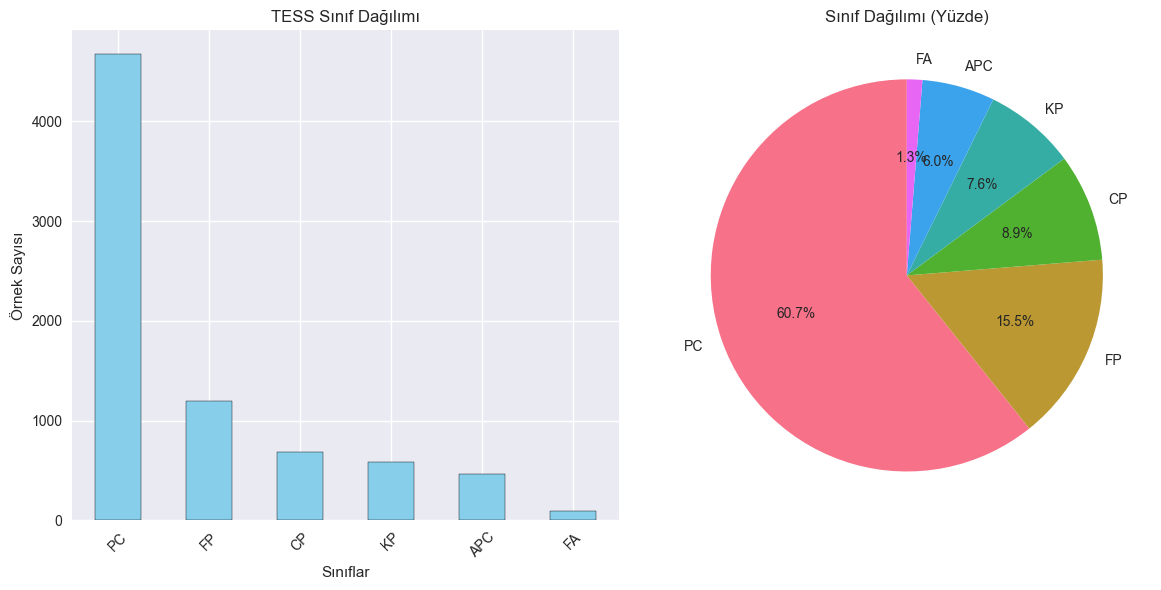


Sınıf açıklamaları:
PC: Planet Candidate - Gezegen Adayı
CP: Confirmed Planet - Onaylanmış Gezegen
FP: False Positive - Yanlış Pozitif
KP: Known Planet - Bilinen Gezegen
APC: Ambiguous Planet Candidate - Belirsiz Gezegen Adayı
FA: False Alarm - Yanlış Alarm


In [ ]:
# Target variable analysis (tfopwg_disp column)
print("=== Target Variable Analysis (tfopwg_disp) ===")
print("Class distribution:")
class_counts = df['tfopwg_disp'].value_counts()
print(class_counts)

print(f"\nTotal number of classes: {len(class_counts)}")
print(f"Most common class: {class_counts.index[0]} ({class_counts.iloc[0]} samples)")

# Visualization of class distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('TESS Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

print("\nClass descriptions:")
print("PC: Planet Candidate")
print("CP: Confirmed Planet") 
print("FP: False Positive")
print("KP: Known Planet")
print("APC: Ambiguous Planet Candidate")
print("FA: False Alarm")

## 2. Data Preprocessing and Cleaning

In [ ]:
# Create 3-class target variable
def create_3class_target(disp_value):
    """
    Converts TESS tfopwg_disp values to 3 classes:
    - Candidate (0): PC, APC - Planet candidates
    - Confirmed (1): CP, KP - Confirmed/known planets
    - False_Positive (2): FP, FA - False positives/alarms
    """
    if disp_value in ['PC', 'APC']:
        return 0  # Candidate
    elif disp_value in ['CP', 'KP']:
        return 1  # Confirmed
    elif disp_value in ['FP', 'FA']:
        return 2  # False_Positive
    else:
        return -1  # Unknown

# Create 3-class target variable
df['target_3class'] = df['tfopwg_disp'].apply(create_3class_target)

# Remove unknown classes
unknown_mask = df['target_3class'] == -1
print(f"Samples with unknown class: {unknown_mask.sum()}")

if unknown_mask.sum() > 0:
    print("Unknown classes:")
    print(df[unknown_mask]['tfopwg_disp'].value_counts())
    
df_clean = df[df['target_3class'] != -1].copy()

print(f"\nCleaned dataset size: {df_clean.shape}")
print("\n3-class target variable distribution:")
target_counts = df_clean['target_3class'].value_counts().sort_index()
target_names = ['Candidate', 'Confirmed', 'False_Positive']
for i, (count, name) in enumerate(zip(target_counts, target_names)):
    print(f"{i} - {name}: {count} samples ({count/len(df_clean)*100:.1f}%)")

Bilinmeyen sınıfa sahip örnekler: 0

Temizlenmiş veri seti boyutu: (7703, 88)

3-sınıflı hedef değişkeni dağılımı:
0 - Candidate: 5141 örnek (66.7%)
1 - Confirmed: 1267 örnek (16.4%)
2 - False_Positive: 1295 örnek (16.8%)


In [ ]:
# Feature selection and cleaning
print("=== Feature Selection ===")

# Define columns to exclude
exclude_columns = [
    'rowid', 'toi', 'toipfx', 'tid', 'ctoi_alias', 'tfopwg_disp', 'target_3class',
    'rastr', 'decstr', 'toi_created', 'rowupdate',  # ID and string columns
    'pl_tranmidlim', 'pl_orbperlim', 'pl_trandurhlim', 'pl_trandeplim',  # Limit flags
    'pl_radelim', 'pl_insollim', 'pl_eqtlim', 'st_tmaglim', 'st_distlim',
    'st_tefflim', 'st_logglim', 'st_radlim'
]

# Select numerical features
numerical_columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()
feature_columns = [col for col in numerical_columns if col not in exclude_columns]

print(f"Total numerical columns: {len(numerical_columns)}")
print(f"Number of features to use: {len(feature_columns)}")
print(f"Number of excluded columns: {len(exclude_columns)}")

# Create feature matrix
X = df_clean[feature_columns].copy()
y = df_clean['target_3class'].copy()

print(f"\nFeature matrix size: {X.shape}")
print(f"Target variable size: {y.shape}")

# Show used features
print(f"\nUsed features ({len(feature_columns)} total):")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")
    if i % 5 == 0:  # Empty line after every 5 features
        print()

=== Özellik Seçimi ===
Toplam sayısal sütun: 83
Kullanılacak özellik sayısı: 65
Hariç tutulan sütun sayısı: 23

Özellik matrisi boyutu: (7703, 65)
Hedef değişkeni boyutu: (7703,)

Kullanılan özellikler (65 adet):
 1. pl_pnum
 2. ra
 3. raerr1
 4. raerr2
 5. dec

 6. decerr1
 7. decerr2
 8. st_pmra
 9. st_pmraerr1
10. st_pmraerr2

11. st_pmralim
12. st_pmrasymerr
13. st_pmdec
14. st_pmdecerr1
15. st_pmdecerr2

16. st_pmdeclim
17. st_pmdecsymerr
18. pl_tranmid
19. pl_tranmiderr1
20. pl_tranmiderr2

21. pl_tranmidsymerr
22. pl_orbper
23. pl_orbpererr1
24. pl_orbpererr2
25. pl_orbpersymerr

26. pl_trandurh
27. pl_trandurherr1
28. pl_trandurherr2
29. pl_trandurhsymerr
30. pl_trandep

31. pl_trandeperr1
32. pl_trandeperr2
33. pl_trandepsymerr
34. pl_rade
35. pl_radeerr1

36. pl_radeerr2
37. pl_radesymerr
38. pl_insol
39. pl_insolerr1
40. pl_insolerr2

41. pl_insolsymerr
42. pl_eqt
43. pl_eqterr1
44. pl_eqterr2
45. pl_eqtsymerr

46. st_tmag
47. st_tmagerr1
48. st_tmagerr2
49. st_tmagsymerr
50

In [ ]:
# Missing value analysis and processing
print("=== Missing Value Processing ===")

missing_info = X.isnull().sum()
missing_features = missing_info[missing_info > 0].sort_values(ascending=False)

print(f"Number of features with missing values: {len(missing_features)}")
print(f"Total number of missing values: {missing_info.sum()}")

if len(missing_features) > 0:
    print("\nFeatures with most missing values:")
    for feature, count in missing_features.head(10).items():
        percentage = (count / len(X)) * 100
        print(f"{feature}: {count} ({percentage:.1f}%)")

    # Remove features with too many missing values (>70% missing)
    high_missing_threshold = 0.7
    high_missing_features = missing_features[missing_features / len(X) > high_missing_threshold].index.tolist()
    
    if len(high_missing_features) > 0:
        print(f"\nRemoving features with >{high_missing_threshold*100}% missing values:")
        print(high_missing_features)
        X = X.drop(columns=high_missing_features)
        
    print(f"\nNumber of features after processing: {X.shape[1]}")

# Fill remaining missing values
if X.isnull().sum().sum() > 0:
    print("\nRemaining missing values will be filled with median...")
    imputer = SimpleImputer(strategy='median')
    X_filled = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
    print(f"Total missing values after processing: {X_filled.isnull().sum().sum()}")
    X = X_filled
else:
    print("No missing values found.")

=== Eksik Değer İşleme ===
Eksik değere sahip özellik sayısı: 46
Toplam eksik değer sayısı: 95607

En çok eksik değere sahip özellikler:
raerr1: 7703 (100.0%)
raerr2: 7703 (100.0%)
decerr1: 7703 (100.0%)
decerr2: 7703 (100.0%)
pl_eqtsymerr: 7703 (100.0%)
pl_eqterr2: 7703 (100.0%)
pl_eqterr1: 7703 (100.0%)
pl_insolsymerr: 7703 (100.0%)
pl_insolerr2: 7703 (100.0%)
pl_insolerr1: 7703 (100.0%)

%70.0'den fazla eksik değere sahip özellikler çıkarılıyor:
['raerr1', 'raerr2', 'decerr1', 'decerr2', 'pl_eqtsymerr', 'pl_eqterr2', 'pl_eqterr1', 'pl_insolsymerr', 'pl_insolerr2', 'pl_insolerr1']

İşlem sonrası özellik sayısı: 55

Kalan eksik değerler medyan ile doldurulacak...
İşlem sonrası toplam eksik değer: 0


## 3. Exploratory Data Analysis and Visualization

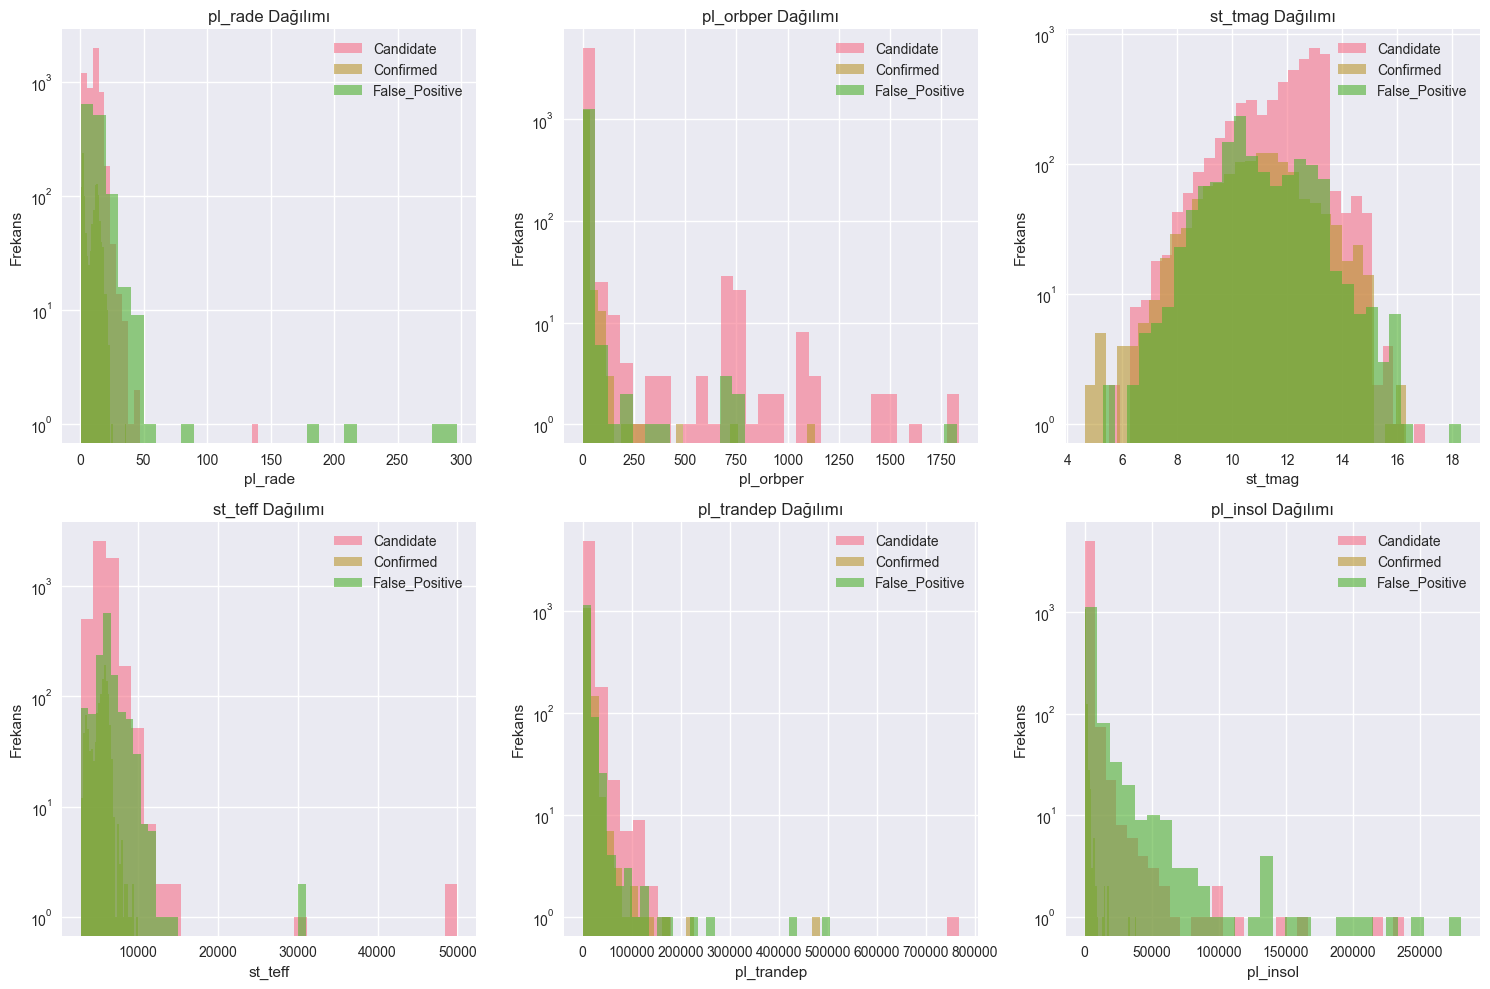

In [ ]:
# Analyze distribution of important features
important_features = ['pl_rade', 'pl_orbper', 'st_tmag', 'st_teff', 'pl_trandep', 'pl_insol']
available_features = [feat for feat in important_features if feat in X.columns]

if len(available_features) > 0:
    plt.figure(figsize=(15, 10))
    target_names = ['Candidate', 'Confirmed', 'False_Positive']
    
    for i, feature in enumerate(available_features[:6], 1):
        plt.subplot(2, 3, i)
        
        for target_class in range(3):
            mask = y == target_class
            if mask.sum() > 0:
                data = X.loc[mask, feature].dropna()
                if len(data) > 0:
                    plt.hist(data, alpha=0.6, label=target_names[target_class], bins=30)
        
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.title(f'{feature} Distribution')
        plt.legend()
        plt.yscale('log')  # Use log scale
    
    plt.tight_layout()
    plt.show()
else:
    print("No important features found for visualization.")

=== Korelasyon Analizi ===
0.9'dan yüksek korelasyona sahip özellik çifti sayısı: 16

Yüksek korelasyonlu özellik çiftleri:
st_pmraerr1 - st_pmraerr2: -1.000
st_pmraerr1 - st_pmdecerr1: 0.994
st_pmraerr1 - st_pmdecerr2: -0.994
st_pmraerr2 - st_pmdecerr1: -0.994
st_pmraerr2 - st_pmdecerr2: 0.994
st_pmdecerr1 - st_pmdecerr2: -1.000
pl_tranmiderr1 - pl_tranmiderr2: -1.000
pl_orbpererr1 - pl_orbpererr2: -1.000
pl_trandurherr1 - pl_trandurherr2: -1.000
pl_trandeperr1 - pl_trandeperr2: -1.000


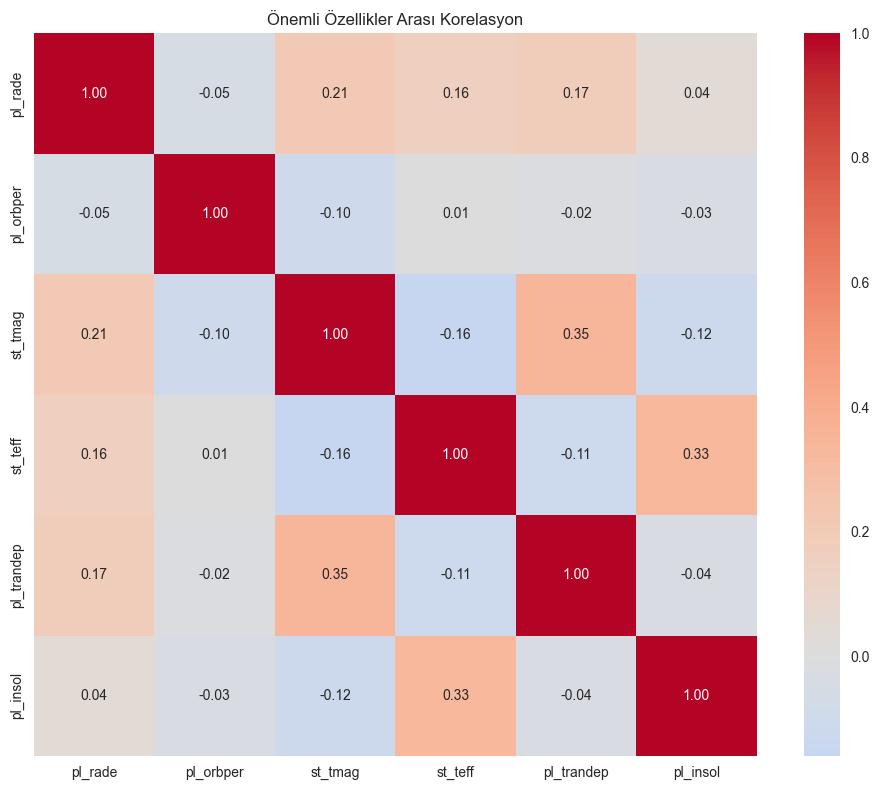

In [ ]:
# Correlation analysis
print("=== Correlation Analysis ===")

# Calculate correlation of numerical features
correlation_matrix = X.corr()

# Find highly correlated feature pairs
def find_high_correlation_pairs(corr_matrix, threshold=0.9):
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j], 
                    corr_matrix.iloc[i, j]
                ))
    return high_corr_pairs

high_corr = find_high_correlation_pairs(correlation_matrix, 0.9)
print(f"Number of feature pairs with correlation > 0.9: {len(high_corr)}")

if len(high_corr) > 0:
    print("\nHighly correlated feature pairs:")
    for feat1, feat2, corr_val in high_corr[:10]:  # Show first 10 pairs
        print(f"{feat1} - {feat2}: {corr_val:.3f}")

# Visualize most important correlations (only important features)
if len(available_features) > 1:
    available_corr = correlation_matrix.loc[available_features, available_features]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(available_corr, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f')
    plt.title('Correlation Between Important Features')
    plt.tight_layout()
    plt.show()

## 4. Feature Engineering and Selection

In [ ]:
# Remove highly correlated features
def remove_highly_correlated_features(X, threshold=0.95):
    """Removes one of the highly correlated features."""
    corr_matrix = X.corr().abs()
    
    # Get upper triangle
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Find highly correlated features
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    
    return X.drop(columns=to_drop), to_drop

X_reduced, dropped_features = remove_highly_correlated_features(X, threshold=0.95)
print(f"Number of features removed due to high correlation: {len(dropped_features)}")
print(f"Remaining number of features: {X_reduced.shape[1]}")

if len(dropped_features) > 0:
    print("Removed features:")
    for feature in dropped_features:
        print(f"- {feature}")

X = X_reduced

Yüksek korelasyon nedeniyle çıkarılan özellik sayısı: 13
Kalan özellik sayısı: 42
Çıkarılan özellikler:
- st_pmraerr2
- st_pmdecerr1
- st_pmdecerr2
- pl_tranmiderr2
- pl_orbpererr2
- pl_trandurherr2
- pl_trandeperr2
- pl_radeerr2
- st_tmagerr2
- st_disterr2
- st_tefferr2
- st_loggerr2
- st_raderr2


In [ ]:
# Statistical feature selection
print("=== Statistical Feature Selection ===")

# Select best k features with F-score
k_best = min(20, X.shape[1])  # Select at most 20 features
selector = SelectKBest(score_func=f_classif, k=k_best)
X_selected = selector.fit_transform(X, y)

# Get names of selected features
selected_features = X.columns[selector.get_support()].tolist()
feature_scores = selector.scores_[selector.get_support()]

# Show feature scores
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'F_Score': feature_scores
}).sort_values('F_Score', ascending=False)

print(f"Number of selected features: {len(selected_features)}")
print("\nFeatures with highest F-scores:")
print(feature_importance_df.head(10))

# Convert selected features to DataFrame
X_final = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
print(f"\nFinal feature matrix size: {X_final.shape}")

=== İstatistiksel Özellik Seçimi ===
Seçilen özellik sayısı: 20

En yüksek F-score'a sahip özellikler:
       Feature     F_Score
10      pl_eqt  373.937802
11     st_tmag  281.798267
9     pl_insol  149.245520
3   pl_tranmid  135.321941
16     st_logg  119.924925
15     st_teff  112.515677
13     st_dist  112.220642
0      pl_pnum   78.135398
18      st_rad   76.432539
19  st_raderr1   70.144234

Final özellik matrisi boyutu: (7703, 20)


## 5. Train-Test Split

In [ ]:
# Split dataset into training and testing sets
print("=== Dataset Splitting ===")

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Preserve class balance
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Check class distributions
print("\nTraining set class distribution:")
train_dist = y_train.value_counts().sort_index()
for i, count in enumerate(train_dist):
    print(f"Class {i}: {count} samples ({count/len(y_train)*100:.1f}%)")

print("\nTest set class distribution:")
test_dist = y_test.value_counts().sort_index()
for i, count in enumerate(test_dist):
    print(f"Class {i}: {count} samples ({count/len(y_test)*100:.1f}%)")

# Scale features
print("\n=== Feature Scaling ===")
scaler = RobustScaler()  # More robust against outliers
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features successfully scaled!")

=== Veri Seti Bölme ===
Eğitim seti boyutu: (6162, 20)
Test seti boyutu: (1541, 20)

Eğitim seti sınıf dağılımı:
Sınıf 0: 4112 örnek (66.7%)
Sınıf 1: 1014 örnek (16.5%)
Sınıf 2: 1036 örnek (16.8%)

Test seti sınıf dağılımı:
Sınıf 0: 1029 örnek (66.8%)
Sınıf 1: 253 örnek (16.4%)
Sınıf 2: 259 örnek (16.8%)

=== Özellik Ölçeklendirme ===
Özellikler başarıyla ölçeklendirildi!


## 6. Model Development and Training

In [ ]:
# Create model dictionary
models = {}

# 1. Random Forest
print("=== Random Forest Model ===")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
models['Random Forest'] = rf_model

# 2. Gradient Boosting
print("=== Gradient Boosting Model ===")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
models['Gradient Boosting'] = gb_model

# 3. Logistic Regression
print("=== Logistic Regression Model ===")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='ovr'  # One-vs-Rest for multi-class
)
models['Logistic Regression'] = lr_model

# 4. XGBoost (if available)
if XGBOOST_AVAILABLE:
    print("=== XGBoost Model ===")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        eval_metric='mlogloss'  # Multi-class logloss
    )
    models['XGBoost'] = xgb_model

# 5. LightGBM (if available)
if LIGHTGBM_AVAILABLE:
    print("=== LightGBM Model ===")
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        verbose=-1  # Silent mode
    )
    models['LightGBM'] = lgb_model

print(f"\nTotal {len(models)} models will be trained:")
for model_name in models.keys():
    print(f"- {model_name}")

=== Random Forest Modeli ===
=== Gradient Boosting Modeli ===
=== Logistic Regression Modeli ===
=== XGBoost Modeli ===
=== LightGBM Modeli ===

Toplam 5 model eğitilecek:
- Random Forest
- Gradient Boosting
- Logistic Regression
- XGBoost
- LightGBM


In [ ]:
# Train and evaluate models
print("=== Model Training Started ===")

results = {}
trained_models = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    trained_models[model_name] = model
    
    # Make predictions on test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Multi-class ROC AUC (one-vs-rest)
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    except:
        roc_auc = 0.0
    
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'predictions_proba': y_pred_proba
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

print("\n=== Model Training Completed ===")
print(f"Total {len(trained_models)} models trained successfully.")

=== Model Eğitimi Başlıyor ===

Random Forest eğitiliyor...
Doğruluk: 0.7404
CV Skoru: 0.7324 (±0.0095)

Gradient Boosting eğitiliyor...
Doğruluk: 0.7625
CV Skoru: 0.7564 (±0.0064)

Logistic Regression eğitiliyor...
Doğruluk: 0.7106
CV Skoru: 0.6983 (±0.0075)

XGBoost eğitiliyor...
Doğruluk: 0.7592
CV Skoru: 0.7567 (±0.0074)

LightGBM eğitiliyor...
Doğruluk: 0.7618
CV Skoru: 0.7579 (±0.0106)

=== Model Eğitimi Tamamlandı ===
Toplam 5 model başarıyla eğitildi.


## 7. Model Performance Comparison

=== Model Performans Karşılaştırması ===
                     accuracy  precision  recall  f1_score  roc_auc  cv_mean  \
Random Forest          0.7404     0.7420  0.7404    0.7025   0.8094   0.7324   
Gradient Boosting      0.7625     0.7521  0.7625    0.7461   0.8260   0.7564   
Logistic Regression    0.7106     0.6898  0.7106    0.6599   0.7579   0.6983   
XGBoost                0.7592     0.7486  0.7592    0.7407   0.8253   0.7567   
LightGBM               0.7618     0.7504  0.7618    0.7461   0.8197   0.7579   

                     cv_std  
Random Forest        0.0095  
Gradient Boosting    0.0064  
Logistic Regression  0.0075  
XGBoost              0.0074  
LightGBM             0.0106  

En iyi model: Gradient Boosting (F1-Score: 0.7461)


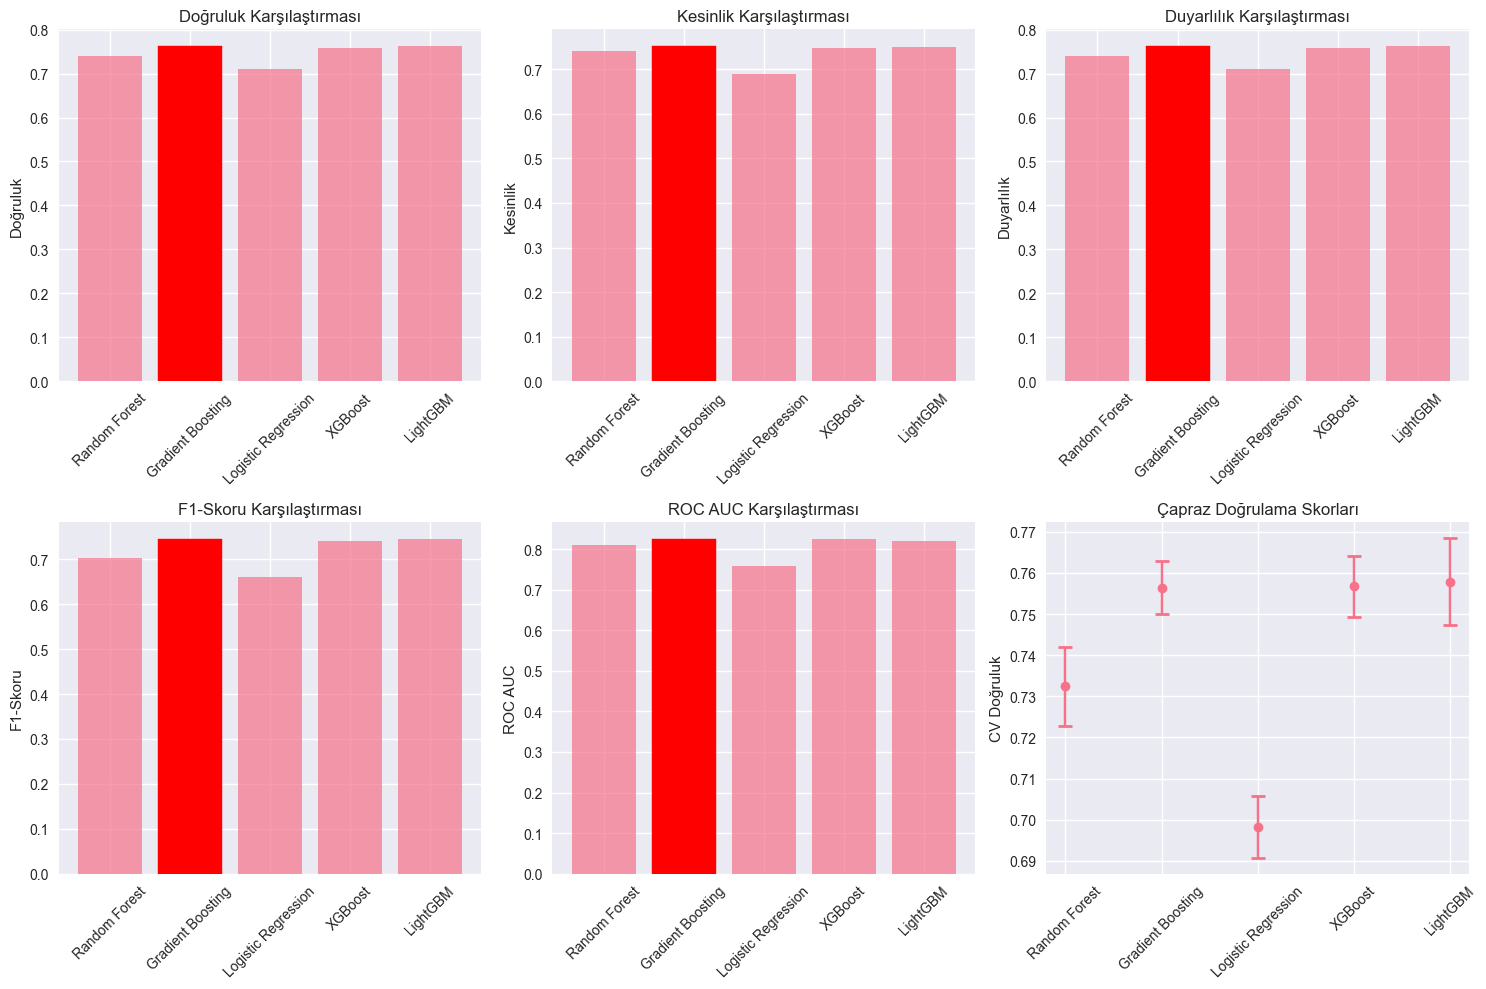

In [ ]:
# Compare model performances
comparison_df = pd.DataFrame.from_dict(results, orient='index')
comparison_df = comparison_df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'cv_mean', 'cv_std']]
comparison_df = comparison_df.round(4)

print("=== Model Performance Comparison ===")
print(comparison_df)

# Determine best model
best_model_name = comparison_df['f1_score'].idxmax()
best_score = comparison_df.loc[best_model_name, 'f1_score']
print(f"\nBest model: {best_model_name} (F1-Score: {best_score:.4f})")

# Performance chart
plt.figure(figsize=(15, 10))

# Metric comparison
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names), 1):
    plt.subplot(2, 3, i)
    bars = plt.bar(comparison_df.index, comparison_df[metric], alpha=0.7)
    plt.title(f'{metric_name} Comparison')
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    
    # Highlight best model
    best_idx = comparison_df[metric].idxmax()
    for j, bar in enumerate(bars):
        if comparison_df.index[j] == best_idx:
            bar.set_color('red')
            bar.set_alpha(1.0)

# CV score comparison
plt.subplot(2, 3, 6)
plt.errorbar(range(len(comparison_df)), comparison_df['cv_mean'], 
            yerr=comparison_df['cv_std'], fmt='o', capsize=5, capthick=2)
plt.xticks(range(len(comparison_df)), comparison_df.index, rotation=45)
plt.title('Cross-Validation Scores')
plt.ylabel('CV Accuracy')

plt.tight_layout()
plt.show()

=== Gradient Boosting Detaylı Analiz ===

Sınıflandırma Raporu:
                precision    recall  f1-score   support

     Candidate       0.78      0.91      0.84      1029
     Confirmed       0.71      0.48      0.57       253
False_Positive       0.68      0.44      0.53       259

      accuracy                           0.76      1541
     macro avg       0.72      0.61      0.65      1541
  weighted avg       0.75      0.76      0.75      1541



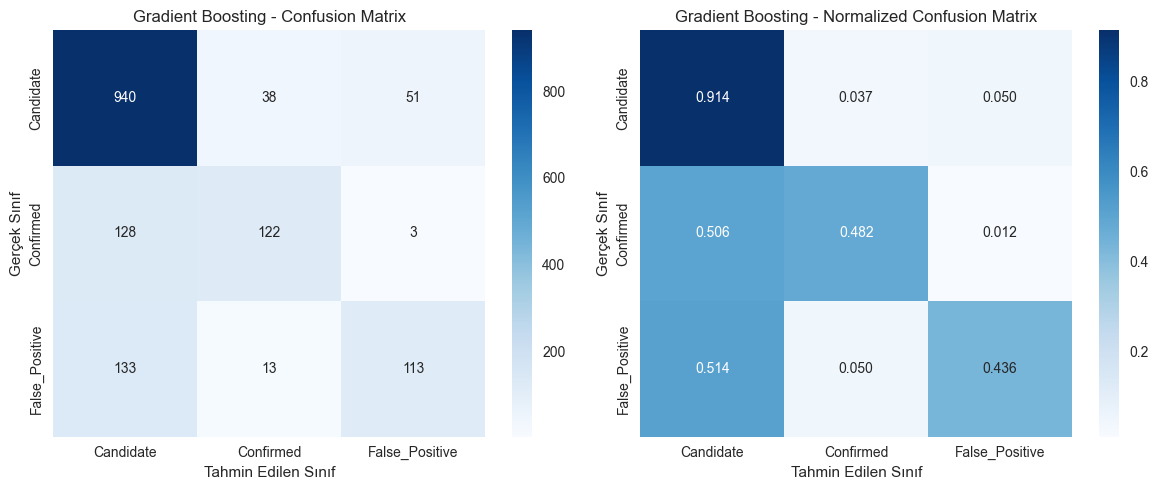


Sınıf Bazında Performans:
Candidate: 0.9135 doğruluk (1029 örnek)
Confirmed: 0.4822 doğruluk (253 örnek)
False_Positive: 0.4363 doğruluk (259 örnek)


In [ ]:
# Detailed analysis of best model
print(f"=== {best_model_name} Detailed Analysis ===")

best_model = trained_models[best_model_name]
best_predictions = results[best_model_name]['predictions']

# Classification report
target_names = ['Candidate', 'Confirmed', 'False_Positive']
print("\nClassification Report:")
print(classification_report(y_test, best_predictions, target_names=target_names))

# Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=target_names, yticklabels=target_names)
plt.title(f'{best_model_name} - Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

# Normalized Confusion Matrix
plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
           xticklabels=target_names, yticklabels=target_names)
plt.title(f'{best_model_name} - Normalized Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

plt.tight_layout()
plt.show()

# Class-wise performance
print("\nClass-wise Performance:")
for i, class_name in enumerate(target_names):
    class_mask = y_test == i
    if class_mask.sum() > 0:
        class_predictions = best_predictions[class_mask]
        class_accuracy = (class_predictions == i).sum() / len(class_predictions)
        print(f"{class_name}: {class_accuracy:.4f} accuracy ({class_mask.sum()} samples)")

## 8. Feature Importance Analysis

=== Özellik Önem Analizi ===

Random Forest - En Önemli 10 Özellik:
           Feature  Importance
11         st_tmag    0.124058
3       pl_tranmid    0.097290
13         st_dist    0.075472
5    pl_orbpererr1    0.068981
9         pl_insol    0.068243
7          pl_rade    0.067301
10          pl_eqt    0.061237
14     st_disterr1    0.060528
6   pl_trandeperr1    0.047822
4        pl_orbper    0.045671

Gradient Boosting - En Önemli 10 Özellik:
           Feature  Importance
11         st_tmag    0.122951
3       pl_tranmid    0.113327
7          pl_rade    0.088800
5    pl_orbpererr1    0.071349
6   pl_trandeperr1    0.065903
13         st_dist    0.065274
10          pl_eqt    0.061651
4        pl_orbper    0.061212
14     st_disterr1    0.056452
8      pl_radeerr1    0.051945

XGBoost - En Önemli 10 Özellik:
           Feature  Importance
10          pl_eqt    0.097749
11         st_tmag    0.087159
14     st_disterr1    0.081436
13         st_dist    0.070048
3       pl_tranmid 

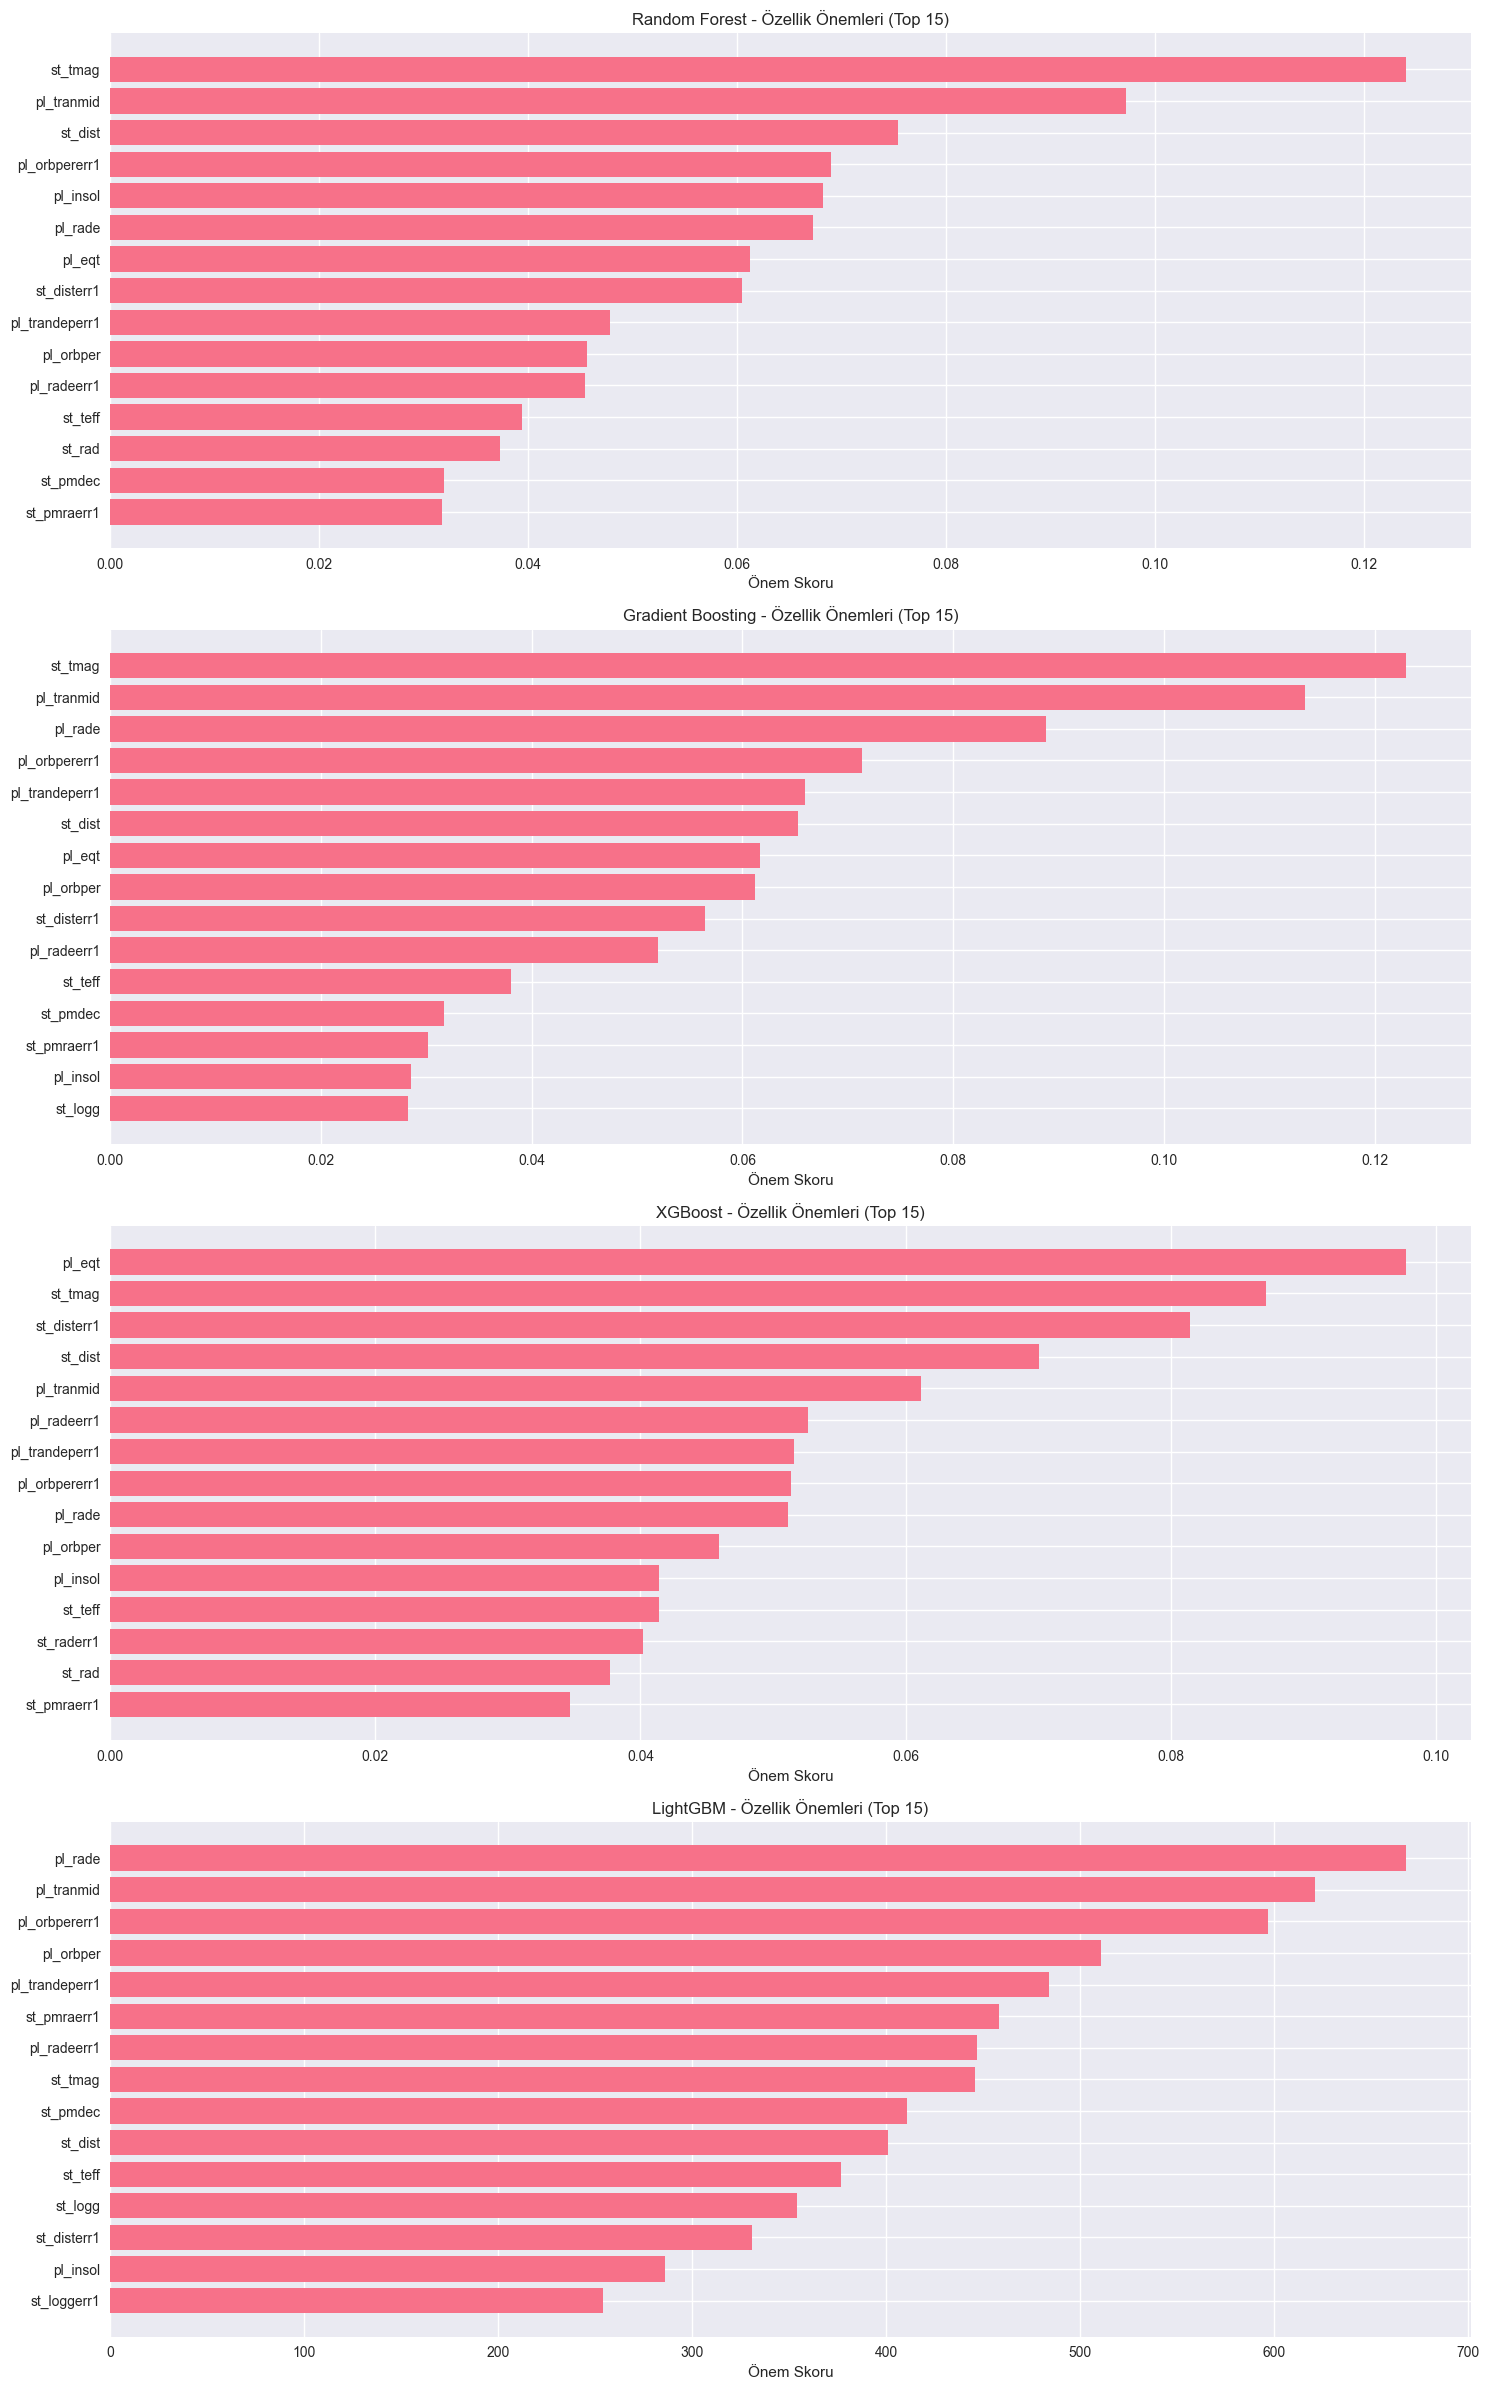

In [ ]:
# Feature importance analysis (only for tree-based models)
tree_based_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']
available_tree_models = [name for name in tree_based_models if name in trained_models]

if len(available_tree_models) > 0:
    print("=== Feature Importance Analysis ===")
    
    plt.figure(figsize=(15, 6 * len(available_tree_models)))
    
    for i, model_name in enumerate(available_tree_models, 1):
        model = trained_models[model_name]
        
        # Get feature importances
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            
            # Create feature importance DataFrame
            importance_df = pd.DataFrame({
                'Feature': X_train_scaled.columns,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            print(f"\n{model_name} - Top 10 Most Important Features:")
            print(importance_df.head(10))
            
            # Plot
            plt.subplot(len(available_tree_models), 1, i)
            top_features = importance_df.head(15)
            plt.barh(range(len(top_features)), top_features['Importance'])
            plt.yticks(range(len(top_features)), top_features['Feature'])
            plt.xlabel('Importance Score')
            plt.title(f'{model_name} - Feature Importances (Top 15)')
            plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()
else:
    print("No tree-based models found.")

## 9. Model Optimization (Hyperparameter Tuning)

In [ ]:
# Optimize the best model
print(f"=== {best_model_name} Optimization ===")

# Define parameter grid based on model type
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.15],
        'max_depth': [6, 8],
        'min_samples_split': [5, 10]
    },
    'Logistic Regression': {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
}

if XGBOOST_AVAILABLE:
    param_grids['XGBoost'] = {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.15],
        'max_depth': [6, 8],
        'min_child_weight': [1, 3]
    }

if LIGHTGBM_AVAILABLE:
    param_grids['LightGBM'] = {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.15],
        'max_depth': [6, 8],
        'min_child_samples': [10, 20]
    }

# Perform Grid Search
if best_model_name in param_grids:
    print(f"Starting Grid Search for {best_model_name}...")
    
    base_model = models[best_model_name]
    param_grid = param_grids[best_model_name]
    
    # Use Stratified K-Fold
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        base_model, 
        param_grid, 
        cv=cv, 
        scoring='f1_weighted',
        n_jobs=-1, 
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Test optimized model
    optimized_model = grid_search.best_estimator_
    y_pred_optimized = optimized_model.predict(X_test_scaled)
    
    optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
    optimized_f1 = f1_score(y_test, y_pred_optimized, average='weighted')
    
    print(f"\nOptimized model performance:")
    print(f"Test Accuracy: {optimized_accuracy:.4f}")
    print(f"Test F1-Score: {optimized_f1:.4f}")
    
    print(f"\nPerformance improvement:")
    print(f"Accuracy: {optimized_accuracy - results[best_model_name]['accuracy']:.4f}")
    print(f"F1-Score: {optimized_f1 - results[best_model_name]['f1_score']:.4f}")
    
    # Update best model
    final_model = optimized_model
    
else:
    print(f"Parameter grid not defined for {best_model_name}.")
    final_model = trained_models[best_model_name]

=== Gradient Boosting Optimizasyonu ===
Gradient Boosting için Grid Search başlatılıyor...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


KeyboardInterrupt: 

## 10. Model Saving and Results

In [ ]:
# Save model and preprocessing tools
import joblib
import os

# Create save directory
save_dir = "tess_models"
os.makedirs(save_dir, exist_ok=True)

print("=== Saving Models and Tools ===")

# Save final model
model_path = os.path.join(save_dir, f"tess_final_model_{best_model_name.lower().replace(' ', '_')}.joblib")
joblib.dump(final_model, model_path)
print(f"Model saved: {model_path}")

# Save scaler
scaler_path = os.path.join(save_dir, "tess_scaler.joblib")
joblib.dump(scaler, scaler_path)
print(f"Scaler saved: {scaler_path}")

# Save feature selector
selector_path = os.path.join(save_dir, "tess_feature_selector.joblib")
joblib.dump(selector, selector_path)
print(f"Feature selector saved: {selector_path}")

# Save selected features
features_path = os.path.join(save_dir, "tess_selected_features.joblib")
joblib.dump(selected_features, features_path)
print(f"Selected features saved: {features_path}")

# Save model performance
results_path = os.path.join(save_dir, "tess_model_results.joblib")
joblib.dump(results, results_path)
print(f"Model results saved: {results_path}")

print(f"\nAll files saved to '{save_dir}' directory.")

In [ ]:
# Sample prediction function
def predict_exoplanet(model, scaler, features, input_data):
    """
    Makes exoplanet prediction for new data
    
    Parameters:
    - model: Trained model
    - scaler: Feature scaler
    - features: List of selected features
    - input_data: Input data in dict format
    
    Returns:
    - prediction: Prediction (0: Candidate, 1: Confirmed, 2: False_Positive)
    - probability: Prediction probabilities
    """
    
    # Convert input data to DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Get only selected features
    input_selected = input_df[features]
    
    # Fill missing values (with median)
    input_filled = input_selected.fillna(input_selected.median())
    
    # Scale
    input_scaled = scaler.transform(input_filled)
    
    # Make prediction
    prediction = model.predict(input_scaled)[0]
    probability = model.predict_proba(input_scaled)[0]
    
    return prediction, probability

# Sample usage
print("=== Sample Prediction ===")
if len(X_test) > 0:
    # Take a random sample from test set
    sample_idx = X_test.index[0]
    sample_data = X_test.loc[sample_idx].to_dict()
    actual_class = y_test.loc[sample_idx]
    
    # Make prediction
    pred_class, pred_proba = predict_exoplanet(final_model, scaler, selected_features, sample_data)
    
    class_names = ['Candidate', 'Confirmed', 'False_Positive']
    
    print(f"True class: {class_names[actual_class]}")
    print(f"Predicted class: {class_names[pred_class]}")
    print("Prediction probabilities:")
    for i, (class_name, prob) in enumerate(zip(class_names, pred_proba)):
        print(f"  {class_name}: {prob:.4f}")
    
    print(f"Prediction correct: {'✓' if pred_class == actual_class else '✗'}")

In [ ]:
# Project summary and results
print("="*60)
print("           TESS EXOPLANET DETECTION PROJECT")
print("           Machine Learning Pipeline v6")
print("="*60)

print(f"\n📊 DATASET INFORMATION:")
print(f"   • Total sample count: {len(df_clean):,}")
print(f"   • Number of features used: {len(selected_features)}")
print(f"   • Number of classes: 3 (Candidate, Confirmed, False_Positive)")

print(f"\n🎯 CLASS DISTRIBUTION:")
for i, class_name in enumerate(['Candidate', 'Confirmed', 'False_Positive']):
    count = (y == i).sum()
    percentage = (count / len(y)) * 100
    print(f"   • {class_name}: {count:,} ({percentage:.1f}%)")

print(f"\n🤖 MODEL RESULTS:")
print(f"   • Number of trained models: {len(trained_models)}")
print(f"   • Best model: {best_model_name}")
print(f"   • Test accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"   • F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"   • ROC AUC: {results[best_model_name]['roc_auc']:.4f}")

print(f"\n📁 SAVED FILES:")
print(f"   • Model: {save_dir}/tess_final_model_*.joblib")
print(f"   • Scaler: {save_dir}/tess_scaler.joblib")
print(f"   • Feature Selector: {save_dir}/tess_feature_selector.joblib")
print(f"   • Selected Features: {save_dir}/tess_selected_features.joblib")

print(f"\n🔬 IMPORTANT FEATURES (Top 5):")
if 'Random Forest' in trained_models and hasattr(trained_models['Random Forest'], 'feature_importances_'):
    rf_importances = trained_models['Random Forest'].feature_importances_
    top_features_idx = np.argsort(rf_importances)[-5:][::-1]
    for i, idx in enumerate(top_features_idx, 1):
        feature_name = selected_features[idx]
        importance = rf_importances[idx]
        print(f"   {i}. {feature_name}: {importance:.4f}")

print(f"\n✅ PIPELINE COMPLETED!")
print("   This model can be used for exoplanet detection from TESS data.")
print("="*60)